# SNR in Fringefit: FFT and Least-Squares versions

Des Small, April 2025

I've spent some time -- possibly too much, on balance -- trying to understand how to calculate signal-to-noise ratios in fringefit algorithms. Since RDAPS is a reboot of Casa, this seemed like a good moment to reevaluate the SNR for the FFT stage of the algorithm. In the context of AIPS, Desai's [KRING](https://library.nrao.edu/public/memos/aips/memos/AIPSM_101.pdf) memo on the subject never got much traction, since the VLBI community has mostly stayed faithful to FRING, but the AIPS FFT stage SNR calculation is ideosyncratic and as far as I know lacks a principled theoretical motivation. 

This memo, which is currently in the form of a Jupyter notebook, will argue that Desai's method is sound and correct, and also consistent with the SNR that can be extracted from a least-squares solver in the global stage. Desai's method is mildly irritating to implement -- it requires a root solver and some Bessel functions, but in 2025 that isn't really a very compelling argument against it.

In [1]:
# Since this is also a notebook with running code we state some dependencies up front.

import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats

## First Principles and Notation

In their indispensible book *Interferometry and Synthesis in Radio Astronomy* (henceforth TMS; A.R. Thompson, J.M. Moran, G.W. Swenson Jr.; ISBN 97833194443), they define the signal to noise problem in terms of a true complex visibility $\mathcal{V}$ which is perturbed by normally distributed noise with zero mean and variance $\sigma$ independently in both the $x$ and the $y$ dimension, leading to a probability distribution for measured visibility $Z = Z_x + j Z_y$ of

\begin{equation}
p(Z_x, Z_y) = \frac{1}{2\pi\sigma^2}\exp\left[-\frac{\left(Z_x+|\mathcal{V}|)^2 + Z_y^2\right)}{2\sigma^2}\right]
\end{equation}

Just to be sure, we transcribe a normal distribution in one dimension, because I am never sure about square roots and factors of two and stuff:

\begin{equation}
N(x; \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp{\left[ -\frac{(x-\mu)^2}{2\sigma^2} \right]}.
\end{equation}

So when you multiply two normal distributions with the same $\sigma$ you have the square of the constant factor, and everything is fine. 

When representing this system diagramatically, TMS take $\mathcal{V}$ to be oriented along the $x$-axis, since it is convenient and can be done without loss of generality. Since I am much lazier than them, I go one step further and decree that the *size* of $\mathcal{V}$ is 1, because then we can represent the SNR as $1/\sigma$ instead of $\mathcal{V}/\sigma$ and again, this is really just a scaling so why not?

And what this is going to mean, in terms of amplitudes, is that the $\sigma$ you put in is going to end up having double the power of a single dimension, so to recover $\sigma$ we have to compensate for that. (Wait, we really mean $1/\sigma$ in most of these places?)

In practice, having two normal distributions of area one in the $x$ and $y$ dimensions means that the amplitude gets scaled up by a factor of $\sqrt{2}$ and the power of the noise by a factor of $2$. You'd think we'd scale the noise down to compensate, but no one ever does so I don't either and if we want to estimate $\sigma$ from the powe of a realisation of a noisy distribution we have, whether we like it or not,

\begin{equation}
\sigma_\mathrm{est} = \sqrt{2\left(\frac{P_\mathrm{signal}}{P_\mathrm{noise}}\right)}
\end{equation}

In [2]:
# I make a class that generates noisy samples of $Z$ in a numpy matrix of given shape.

class NoisySignal(object):
    def __init__(self, snr, shape0):
        self.sigma = 1/snr # By my definition above
        new_shape = tuple(shape0 + (2,))
        noise_r = np.random.normal(0, self.sigma, new_shape)
        noise_c = noise_r.view(dtype=complex).squeeze() 
        # Observed signal is true visibility (by definition here = 1 + 0j) + noise_c:
        self.signal = np.ones(shape0)
        self.noise = noise_c
        self.signal_with_noise = 1+noise_c # Since 
        self.phase = np.angle(self.signal_with_noise)
        self.phasors = np.exp(1J*self.phase)
    def getSignal(self):
        return self.signal_with_noise
    def getPhases(self):
        return self.phase
    def getPhasors(self):
        return self.phasors

## Checking that the power ratios as defined above really do manifest in noisy data

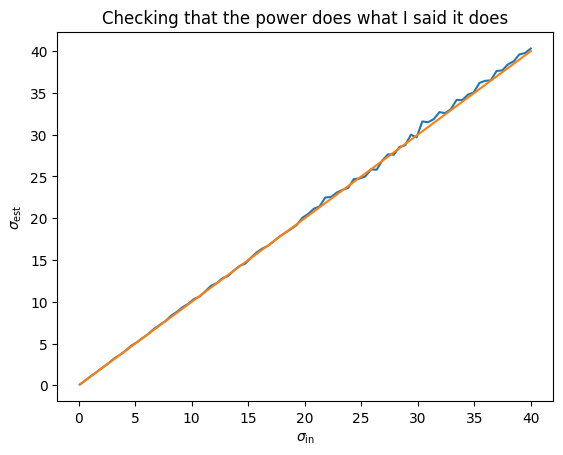

In [3]:
# We pick a range of sigmas
sigmas = np.linspace(0.1, 40, 80)


# and a number of trials to average over for any given sigma
n_trials = 50
l = []
for sigma in sigmas:
    # Then we calculate the power in the signal part and the noise part of our simulated unit visibilities:
    intermediates = []
    for i in range(n_trials):
        ns = NoisySignal(sigma, (50,))
        signal_power = np.sum(ns.signal**2)
        noise_power = (np.sum(ns.noise*ns.noise.conj())).real
        x = np.sqrt(2*signal_power/noise_power)
        intermediates.append(x)
    l.append(np.mean(intermediates))

# And we plot the results to show that we really do get what we expect
plt.plot(sigmas, np.array(l))
plt.plot(sigmas, sigmas);
plt.title("Checking that the power does what I said it does")
plt.xlabel(r"$\sigma_\mathrm{in}$")
plt.ylabel(r"$\sigma_\mathrm{est}$");

## FFT SNRs

We use similar code to generate noisy data and FFT it and look for the peak values. Our SNR results for this section will rely heavily on calculations involving the peak values of the FFT of the noisy unit visibilities.

In [4]:
# A lot of this code is now redundant: it generates noisy data without
# giving access to the signal and noise parts separately because it was 
# written before the above class

def phases_with_noise(snr, shape0):
    sigma = 1/snr
    new_shape = tuple(shape0 + (2,))
    noise_r = np.random.normal(0, sigma, new_shape)
    noise_c = noise_r.view(dtype=complex).squeeze() 
    # Observed signal is true visibility (=1, wlog) + noise_c:
    s0 = 1+noise_c
    # We normalise this
    return np.angle(s0)

def get_peak(snr, npoints):
    p0 = phases_with_noise(snr, (npoints,))
    s1 = np.exp(1J*p0)
    spectrum = np.fft.fft(s1)
    peak = np.max(np.abs(spectrum)) 
    return peak    

npoints = 32

ln_snrs = np.linspace(-3, +2, 100)
snrs = 10**ln_snrs
ntrials = 100

# We use the peaks array in determinations below
peaks = []
for snr in snrs:
    mean_peak = np.mean([get_peak(snr, npoints) for i in range(ntrials)])
    peaks.append(mean_peak)

peaks = np.array(peaks)

### Unsuccessfully reconstruction FRING SNRs

The FRING FFT stage has a calculation of SNR that involves taking powers of the $\tan$ of the peaks, but I haven't actually got that to work here yet. This is unfortunate and needs to be fixed, because the FRING method does actually work OK in practice in the FORTRAN implementation and the CASA fringefit reimplementation.




In [5]:
fring_snr = np.tan(np.pi/2*peaks/npoints)**1.163

1.163*.418

0.486134

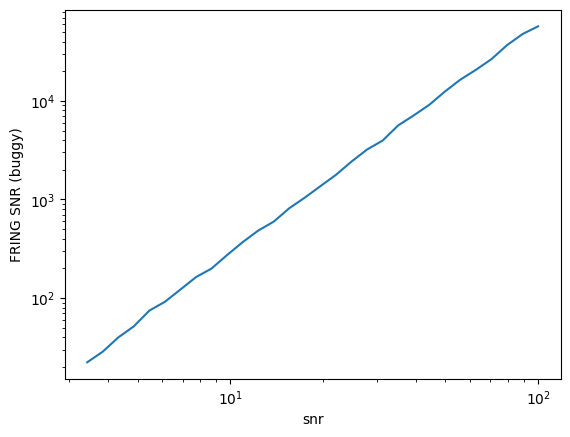

In [9]:
# plt.title("An unsuccessful attempt to emulate AIPS FRING's SNR calculation")
plt.xlabel("snr")
plt.ylabel(r'FRING SNR (buggy)')
alpha = 0.418
plt.plot(snrs[70:], fring_snr[70:])
plt.yscale('log')
plt.xscale('log')
# plt.plot(snrs, snrs)
plt.show()

alpha=0.4976324499846847 np.exp(beta)=0.8896721190645318


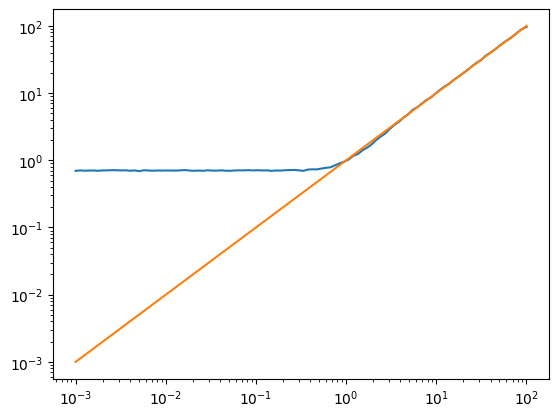

In [51]:
tans = np.tan(np.pi/2*peaks/npoints)

ltans = np.log(tans[70:])
lsnrs = np.log(snrs[70:])

from scipy.optimize import curve_fit
def line(x, a, b):
    return a*x+b

res = curve_fit(line, ltans, lsnrs, p0=(0,1))

alpha, beta = res[0]

ys = np.exp(beta)*tans**alpha
plt.plot(snrs, ys)
plt.plot(snrs, snrs)
print(f"{alpha=} {np.exp(beta)=}")


plt.yscale('log')
plt.xscale('log')
plt.show()

# Warming up with TMS and Vinokur

OK so TMS (section 9.3.3, which expands on 6.2.3) covers some of this in the context of a single noisy visibility. 
I imagine some people have actually read TMS, so we will start with that and fill in some of the details they are too terse to include and generally limber up for the more challenging analysis by Desai.

\begin{equation}
p(Z_x, Z_y) = \frac{1}{2\pi\sigma^2} \exp\left[\frac{(Z_x - |\mathcal{V}|)^2 + Z_y^2}{2\sigma^2}\right]
\end{equation}

Where 
\begin{align}
Z_x &= Z \cos\phi \\
Z_y &= Z \sin\phi
\end{align}
(where $Z = \sqrt{Z_x^2 + Z_y^2}$)

So because the determinant of the Jacobian is $|\mathcal{V}|$ we have

\begin{equation}
p(Z, \phi) = \frac{|\mathcal{V}|}{2\pi\sigma^2} \exp\left[\frac{(Z\cos\phi - |\mathcal{V}|)^2 + Z\sin^2\phi}{2\sigma^2}\right]
\end{equation}

To get the marginal distribution of $p(Z)$ we just integrate over a full circle,
\begin{equation}
p(Z) = \int_0^{2\pi} p(Z,\phi)d\phi,
\end{equation}
so we just expand everything out and pull exponentials with no $\phi$ dependence out in front of the integral using multiplication technology:
\begin{equation}
p(Z) = \frac{|\mathcal{V}|}{2\pi\sigma^2} \exp\left(-\frac{Z^2+|\mathcal{V}|^2}{2\sigma^2}\right)
        \int_{0}^{2\pi} \frac{Z |\mathcal{V}|\cos\phi}{\sigma^2} d\phi.
\end{equation}

And here we enter the realm of the Bessel function. Wikipedia gives a definition of "Modified Bessel functions of the first kind I_\alpha(x)" in terms of integrals; probably reputable sources do too but I am not minded to check. (Mathematica knows these integrals too, by the way, and at the time of writing it's free-as-in-beer on Raspberry Pi linux.) Anyway, here it is:

\begin{equation}
I_\alpha(x) = \frac{1}{\pi}\int_{0}^{\pi} e^{x\cos\theta}\cos\alpha\theta\,d\theta 
         - \frac{\sin\alpha\pi}{\pi}\int_0^\pi e^{-x\cosh(t-\alpha t)}\,dt.
\end{equation}

The first thing to note, with relief, is that the second term vanishes for integer $\alpha$, and we are only going to have integer $\alpha$ throughout this memo, so we can wave a cheery goodby to $\cosh$.

For this single-sample case, in fact, all we need is 
\begin{equation}
I_0 = \frac{1}{\pi}\int_{0}^\pi e^{x\cos\theta}\,d\theta,
\end{equation}
so 
\begin{equation}
p(Z) = \frac{Z}{\sigma^2} \exp\left(-\frac{Z^2+|\mathcal{V}|^2}{2\sigma^2}\right)
        I_0\left(\frac{Z |\mathcal{V}|\cos\phi}{\sigma^2}\right).
\end{equation}

TMS goes on to derive the marginal probabilities of phase, but we aren't going to use that so we don't. TMS say (3rd Ed., p.411) "In the strong-signal case, the statistics of $Z$ are approximately Gaussian, and $\langle Z\rangle$ approaches $\mathcal{V}$. In this case, $N$ samples of $Z$ can be averaged, and the signal-to-noise improves with $\sqrt{N}$.

But where we are actually going is to follow Desai's account of how the statistics of the *Fourier transform* of a grid of measurements of $Z$ + noise behave. 


## Goodman

In this section we follow Goodman's account of the statistical behaviour of a sum of $N$ samples from the noisy distribution.

\begin{equation}
\mathbf{a} = a e^{j\theta} = \frac{1}{\sqrt{N}} \sum_{k=1}^{N} \alpha_k e^{j\phi_k},
\end{equation}
for $a_k$, $\phi_k$ sampled from some underlying distribution.

We ponder real and imaginary parts:
\begin{align}
r &= Re(a e^{j\theta}) &= \frac{1}{\sqrt{N}}\sum_{k=1}^{N} \alpha_k \cos\phi_k \\
i &= Im(a e^{j\theta}) &= \frac{1}{\sqrt{N}}\sum_{k=1}^{N} \alpha_k \sin\phi_k 
\end{align}

We assume that $\alpha_k$ and $\phi_k$ are independent so we can cheerfully assume that $\overline{\alpha_k \phi_k} = \overline{\alpha_k}\cdot{\overline{\phi_k}}$, where we use an overbar to notate the mean.

So

\begin{align}
\overline{r} &= \frac{1}{\sqrt{N}}\sum_{k=1}^{N} \overline{\alpha_k} \overline{\cos{\phi_k}} \\
\overline{i} &= \frac{1}{\sqrt{N}}\sum_{k=1}^{N} \overline{\alpha_k} \overline{\sin{\phi_k}} 
\end{align}

At this point we invoke an important and well-known statistical concept of the "characteristic function". Characteristic functions make it straightforward to calculate the moments of a probability density function (pdf), so the mean (which is the first moment) and variance (which is closely related to the second) can be derived this way. And by a happy circumstance the characteristic function of a pdf is its Fourier transform:

\begin{equation}
M_\phi(\omega) \triangleq \int_{-\infty}^{\infty} \exp(j\omega\phi) p_\phi(\phi)\, d\phi.
\end{equation}

Now we can calculate $\overline{\cos\phi}$ in terms of the characteristic function for an angle $\phi$ given by a pdf which we do not yet specify; the following is true for any pdf $p(\phi)$ with characteristic function $M_\phi(\omega)$:

\begin{align}
   \overline{\cos\phi} &= \int_{-\infty}^{\infty} \cos(\phi) p_\phi(\phi)\, d\phi \\
      &= \int_{-\infty}^{\infty} \frac{e^{j\phi} + e^{-j\phi}}{2} p_\phi(\phi)\, d\phi \\
      &= \frac{1}{2}\int_{-\infty}^{\infty} e^{j\phi} p_\phi(\phi)\, d\phi + 
         \frac{1}{2}\int_{-\infty}^{\infty}e^{-j\phi} p_\phi(\phi)\, d\phi \\
      &= \frac{1}{2}[M_\phi(1) + M_\phi(-1)],
\end{align}
and we have a similar result for $\overline{\cos{\phi}}$ with $\frac{1}{2}[M_\phi(1) + M_\phi(-1)]$. So for our distribution summing $N$ samples we have
\begin{align}
\overline{r} &= \frac{\sqrt{N}\overline{\alpha}}{2} [M_\phi(1) + M_\phi(-1)] \\
\overline{i} &= \frac{\sqrt{N}\overline{\alpha}}{2} [M_\phi(1) - M_\phi(-1)]
\end{align}

We note that if $p_\phi(\phi)$ is an even function--which we are going to arrange!--then
\begin{align}
\overline{r} &= \sqrt{N}\,\overline{\alpha}\, M_\phi(1) \\
\overline{i} &= 0
\end{align}


So now we take a deep breath and try the second moments.

\begin{align}
\overline{r^2} = \frac{1}{N} \sum_{k}\sum_{n} \overline{\alpha_k \alpha_n}\, \overline{\cos{\phi_k}\cos{\phi_n}}
\end{align}

We know that 
\begin{equation}
\sum_{k}\sum_{n} \overline{\alpha_k \alpha_n} = \overline{\alpha}^2 
\end{equation}
(which you can prove for yourself by thinking about it for a moment), and we again decompose the $\cos$ bits by Euler's formula 
and observe that if $n \neq k$ then $\overline{\cos{\phi_k} \cos{\phi_n}} =\overline{\cos{\phi_k}}\,\overline{\cos{\phi_n}}$ to get

\begin{equation}
\overline{\cos\phi_k\cos\phi_n} = 
  \begin{cases}
  \begin{aligned}
     \frac{1}{4}&[2 M_\phi(1) M_\phi(-1) + M^2_\phi(1) + M^2_\phi(-1)], &  k \neq n,\\
     \frac{1}{4}&[2 + M_\phi(2) + M_\phi(-2)],             & k=n.
   \end{aligned}
\end{cases}
\end{equation}

\begin{equation}
\overline{\cos\phi_k\cos\phi_n} = 
  \begin{cases}
  \begin{aligned}
     &M^2_\phi(1),  &  k \neq n,  \\
     &\frac{1}{2}[1 + M_\phi(2)], & k=n.
   \end{aligned}
\end{cases}
\end{equation}


And now we wake, as if from a dream, with the observation that we do in fact know the pdf $p_\phi(\phi)$ after all!

Switching to Desai's notation, in which the the signal-to-noise ratio is denoted by $k$ and we use $\gamma \triangleq \frac{k^2}{4}$ whenever we feel like it,

\begin{equation}
p(\phi) = \frac{e^{-k^2}}{2\pi}  \int_0^\infty x dx e^{-\frac{1}{2}x^2  + x k\cos{\phi}},
\end{equation}
so using $\zeta$, for some reason, as the Fourier pair of $\phi$ we infer that

\begin{align}
M_\phi &= \int_{-\pi}^{\pi} d\phi \, p_\phi(\phi) e^{j\zeta\phi} \\
&= \int_{0}^{\infty} x\,dx e^{-\frac{1}{2}x^2} I_\zeta(kx) \\
  &= e^{-2\alpha} \delta(\zeta)\left( I_{\frac{|\zeta-1|}{2}} (\gamma) + I_{\frac{|\zeta+1|}{2}}(\gamma) \right),
\end{align}
where $I_\zeta$ is the modified Bessel function of integer order, and we remark that $M(\phi)$ is even in $\zeta$, which we have promised several times.

You might ask yourself: what is with all this Bessel function? 

## KRING version of FFT stage


In his memo, K Desai works through a calculation of the moments of the SNR distribution, relying on an appendix of Goodman's *Statistical Optics*  (1960s; currently an expensive Wiley Classic, but my wife's university library had a copy) for the methodology.

I have read this appendix and reproduced the results; they overlap with the treatment in TMS of the Rayleigh distribution in SNR contexts, which they in turn trace back to a [paper by Vinokur](https://adsabs.harvard.edu/full/1965AnAp...28..412V) from 1965. Desai pushes things a bit further, though, and his analysis is nice, so I intend to include a summary of it in this workbook/memo in the future.

The main point of the formula below, in which I have retained Desai's notation with $SNR=k$, is that you can harvest some values from the FFT spectrum and solve a non-linear equation with some Bessel functions to get a principled estimate of the SNR.

$$\frac{\langle X^2_a \rangle T F - \langle w^2\rangle}{\langle w\rangle^2(TF-1)} = G^2\left(\frac{k^2}{4}\right)$$

where 

* $X_a$ is the peak of the amplitude,
* $w$ is weight,
* $T$ is number of timesteps in grid,
* $F$ is number of freqsteps in grid,
* $k$ is SNR and
* $G$ is a complicated Bessel function thing.

Specifically, 

$$G(\gamma) = \sqrt{\frac{\pi\gamma}{2}} \left(I_0(\gamma) + I_1(\gamma)\right)$$

Where $I_n$ is the modified Bessel function of order $n$.

The LHS is all known quantities, so we compute that and use a root solver to invert $G^2$ and find $k$.

The next cell defines Python versions of these formulas, using `scipy`'s very convenient built-in functions for exponentially scaled modified Bessel function of the first kind. (If you're wondering, everything is done via some integrals, and those integrals have closed-form solutions in terms of exactly these functions. I even asked Mathematica, and they agreed it was true.)

In [23]:
from scipy.special import iv, ive

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ive.html#scipy.special.ive
# ive(v, z) = iv(v, z) * exp(-abs(z.real))
# and that's what we need here

def G(gamma):
    t1 = ive(0, gamma) + ive(1, gamma)
    t2 = np.sqrt(np.pi*gamma/2.0)
    return t1*t2

# We use this to solve G(k**2/4) = lhs
from scipy.optimize import root_scalar

def f(k, lhs):
    gamma = (k**2)/4
    return (G(gamma))**2 - lhs

So the next thing to do is to use the values of FFT peaks calculated above and compare (a) our Kring-based estimates and (b) power based estimates with each other and the true value of sigma we put in. Recall from above that we needed to juice the signal-to-noise power formula by a factor of two to get the right value of sigma? Well, we have to bake exactly that into the `snr_by_power` function below to get agreement:

\begin{equation}
\sigma_\mathrm{est} = \sqrt{2\left(\frac{P_\mathrm{signal}}{P_\mathrm{noise}}\right)}
\end{equation}

Then the next Python cells work through those calculations and show that the agreement is very good.

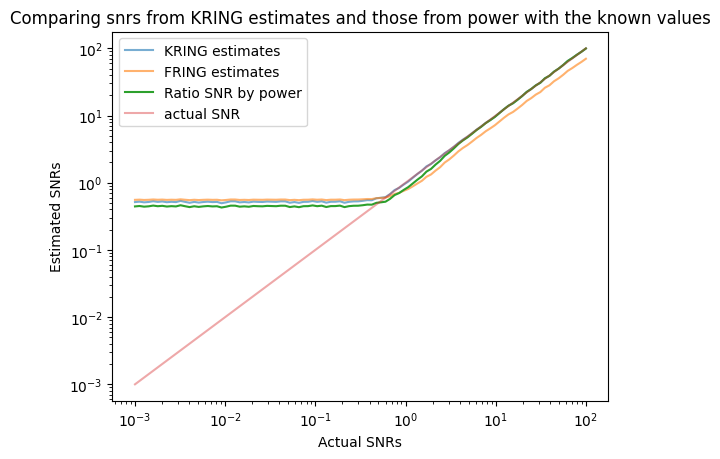

In [24]:
F, T = npoints, 1
w = 1
w_sq = w**2

Xs = peaks/(T*F)

lhss = (Xs**2*T*F-w_sq)/(w**2*(T*F-1))

ks = []
for i,lhs in enumerate(lhss):
    try:
        res = root_scalar(f, args=(lhs,), bracket=(0, 2e3), method='bisect')
        ks.append(res.root)
    except ValueError:
        print(f"Ded after {i}")
        break
    

def snr_by_power(scaled_peak, npoints):
    peak_power = scaled_peak**2
    rest = 1-peak_power
    return np.sqrt(2*scaled_peak/rest)

ss = []
for i,lhs in enumerate(lhss):
    try:
        s = snr_by_power(lhs, npoints)
        ss.append(s)
    except ValueError:
        print(f"Ded after {i}")
        break
ss = np.array(ss)

alpha = 0.418
beta = 0.7
plt.title("Comparing snrs from KRING estimates and those from power with the known values")
plt.plot(snrs[:len(ks)], ks, label='KRING estimates', alpha=0.6)
plt.plot(snrs[:len(ks)], beta*fring_snr[:len(ks)]**alpha, label='FRING estimates', alpha=0.6)
plt.plot(snrs[:len(ks)], ss[:len(ks)], label="Ratio SNR by power") 
plt.plot(snrs[:len(ks)], snrs[:len(ks)], label='actual SNR', alpha=0.4);
plt.ylabel(r"Estimated SNRs")
plt.xlabel(r"Actual SNRs")
plt.yscale('log')
plt.xscale('log')
plt.legend();

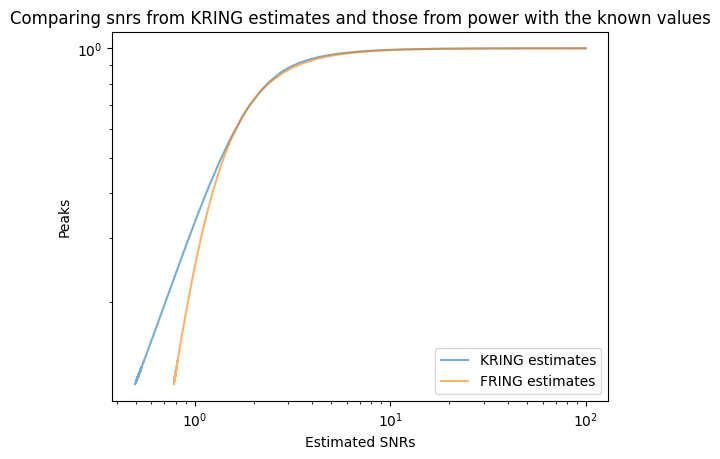

In [25]:
alpha = .418
beta = 1
s_peaks_sq = (peaks/npoints)**2
plt.title("Comparing snrs from KRING estimates and those from power with the known values")
plt.plot(ks, s_peaks_sq[:len(ks)], label='KRING estimates', alpha=0.6)
plt.plot(beta*fring_snr[:len(ks)]**alpha, s_peaks_sq[:len(ks)], label='FRING estimates', alpha=0.6)

plt.xlabel(r"Estimated SNRs")
plt.ylabel(r"Peaks")
plt.yscale('log')
plt.xscale('log')
plt.legend();

### Coda

You might be wondering why we don't just use the power of the noise vs. that of the peak (which we identify with the signal). To be honest, so am I. Please tell me if it's obvious, which it probably is!

# Least Squares SNR

So far we have only looked at the FFT method of fringe fitting, which by definition only uses data from a single baseline. It is also useful to have 

* a global stage of fringefitting, using least squares; and
* a way to calculate SNRs for each antenna from the results of this.

Luckily, this is very possible and was implemented in AIPS FRING. But not in CASA's fringefit task, because I didn't understand how it worked or why it was important. (Now that I do, I may add in back in.)

Using `scipy`'s least_squares method, the composite result included a $\mathtt{jac}$ field which holds an $N\times P$ Jacobian matrix, where $N$ is the number of points fitted and $P$ is the number of parameters. The Hessian can then be approximated by $H = J^T\, J$ and the covariance matrix is simply the inverse of this. So the diagonal entries $H^{-1}_{ii}$ are the solvers estimate of the variance of each parameter. We use the one for the secular phase if there is more than one parameter; that's a measure of the variability of the phase.

Meanwhile, the residual cost of the fit, per point, is another measure of the variability of the phase. 

So we can say, with a modicum of hand-waving, that the noise power estimate is $P_n = \frac{1}{N-P}\sum \sigma^2$ and the signal power estimate is $P_s = N H^{-1}_{ii}$ and that our snr estimate is 
\begin{equation}
\mathrm{snr} = \sqrt\frac{2 P_n}{P_s}.
\end{equation}

And then the next chunk of Python implements that method and again compares the results on noisy simulated data to the known inputs. As a disclaimer: while the least-squares solver is global, we only use it on a single baseline of simulated below. This is after all the critical test: we want to be sure it makes sense there first!

In [27]:
from scipy.optimize import least_squares

class PhaseHolder(object):
    """I use a class to hold the state of the data so I can pass a callable to the Least Squares algorithm"""
    def __init__(self, snr, shape):
        self.sigma = 1/snr
        self.shape0 = shape
        self.phases = self.phases_with_noise()
    def phases_with_noise(self):
        self.signal = np.ones(self.shape0)
        c_shape = tuple(self.shape0 + (2,))
        noise_r = np.random.normal(0, self.sigma, c_shape)
        self.noise = noise_r.view(dtype=complex).squeeze() 
        return np.angle(self.signal + self.noise)
    def model(self, b):
        return np.zeros(self.shape0) + b
    def ls_res(self, b):
        """Generate least-squares residuals.
        This is the method we can pass into scipy.optimize.least_squares"""
        p_model = self.model(b)
        delta_phi = (p_model - self.phases + np.pi) % (2*np.pi) - np.pi
        res = np.ravel(2*np.sin(delta_phi/2))
        return res
    def ls_jac(self, b):
        p_model = self.model(b)
        delta_phi = (self.phases - p_model + np.pi) % (2*np.pi) - np.pi
        res = np.ravel(np.cos(delta_phi/2))
        res2 = np.expand_dims(res, 1)
        return res2

def get_snr(res, n_points, n_params):
    sum_sigma_squared = res.cost
    J = res.jac
    H = J.T @ J # I must admit, this is really nice notation!
    H_inv = np.linalg.inv(H)
    v_1 = 2*sum_sigma_squared /(n_points-n_params) 
    v_2 = n_points*H_inv[0,0] # power in signal; I claim it tends to 1?
    snr = np.sqrt(v_2/v_1) 
    return snr

def matrix_POWER(m):
    return np.sum((m*m.conj()).real)


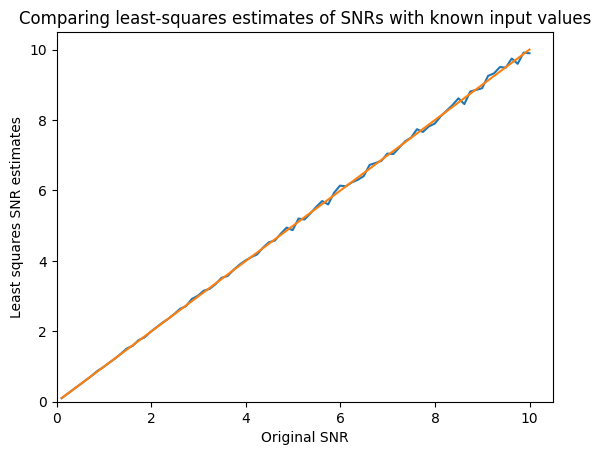

In [28]:
# Now we exercise the above functions and plot a graph:

snrs = np.linspace(0.1, 10, 80)
ntrials = 20
snr_ests = []
p_ests = []
for s in snrs:
    ests = []
    p_trial_ests = []
    for i in range(ntrials):
        ph = PhaseHolder(s, (100,))
        n_points = np.prod(ph.phases.shape)
        n_params = 1
        res = least_squares(ph.ls_res, [np.pi/4], method='lm', jac=ph.ls_jac)
        snr = get_snr(res, n_points, n_params)
        ests.append(snr)
        noise_power = matrix_POWER(ph.noise)
        signal_power = matrix_POWER(ph.signal)
        p_est = np.sqrt(2*signal_power/noise_power)
        p_trial_ests.append(p_est)
    snr_ests.append(np.mean(ests))
    p_ests.append(np.mean(p_trial_ests))
snr_ests = np.array(snr_ests)
p_ests = np.array(p_ests)

plt.title("Comparing least-squares estimates of SNRs with known input values")
#plt.plot(snrs, snr_ests)
plt.plot(snrs, p_ests, label="Power estimates of RMS")
plt.plot(snrs, snrs, label="Input value")
plt.ylim([0, None])
plt.ylabel("Least squares SNR estimates")
plt.xlabel("Original SNR")
plt.xlim([0, None]);

It over-estimates SNR at the low end; I guess there is always some kind of spurious signal to converge to that looks more plausible than declaring that everything is a random mess. I also guess this motivates an SNR cutoff of around 3; at that point you can be modestly confident the signal is actually there.

## Conclusions

I actually thought I had written out a lot more of the mathematical detail in this document than I have. I have many pages of very annoying algebra in my notebooks, and I will transcribe an elegant sufficiency into this notebook in the near future, but there are two key takeaways:

* The KRING SNR calculation is pretty good
* The least squares SNR calculation is fine too; and
* I really need to figure out what's going on with the FRING version; what I have above is clearly wrong.